# ETTS Time-Series Forecasting with S4 (Agnostic Flow)

Train S4 model on Electricity Transformer Temperature (ETT) dataset using the same task-agnostic trainer and evaluation flow as LMU. The configuration is kept generic so we can swap LMU/S4 easily for fair comparison.

In [1]:
from __future__ import annotations
from typing import Dict, Any
from pathlib import Path
import torch

from src.notebooks.etts.utils import ETTSTask, make_block_cfg_ctor, evaluate_best_model

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


## Configuration

In [2]:
current_dir = Path.cwd()
project_root = current_dir.parent.parent.parent
data_root = str(project_root / "src" / "datasets" / "etts" / "data")

# S4-specific base parameters
s4_base_params = {
    "d_state": 64,
    "channels": 1,
    "bidirectional": False,  # Causal for forecasting
    "mode": "s4d",
    "dt_min": 1e-3,
    "dt_max": 1e-1,
}

# --- Agnostic Configurations for each ETT Dataset ---

etth1_config_s4 = {
    "data_root": data_root,
    "batch": 64,
    "epochs": 50,
    "lr": 1e-4,
    "wd": 1e-3,
    "amp": True,
    "save_dir": "./runs/etts_s4_task_h1",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 6,
    "dropout": 0.3,
    "mlp_ratio": 2.0,
    "droppath_final": 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTh1",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    **s4_base_params
}

etth2_config_s4 = {
    "data_root": data_root,
    "batch": 64,
    "epochs": 50,
    "lr": 1e-4,
    "wd": 2e-3,
    "amp": True,
    "save_dir": "./runs/etts_s4_task_h2",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 4,
    "dropout": 0.3,
    "mlp_ratio": 2.0,
    "droppath_final": 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTh2",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    **s4_base_params
}

ettm1_config_s4 = {
    "data_root": data_root,
    "batch": 64,
    "epochs": 50,
    "lr": 1e-4,
    "wd": 2e-3,
    "amp": True,
    "save_dir": "./runs/etts_s4_task_m1",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 4,
    "dropout": 0.3,
    "mlp_ratio": 2.0,
    "droppath_final": 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTm1",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    **s4_base_params
}

ettm2_config_s4 = {
    "data_root": data_root,
    "batch": 64,
    "epochs": 50,
    "lr": 1e-4,
    "wd": 2e-3,
    "amp": True,
    "save_dir": "./runs/etts_s4_task_m2",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 4,
    "dropout": 0.3,
    "mlp_ratio": 2.0,
    "droppath_final": 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTm2",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    **s4_base_params
}

args: Dict[str, Any] = ettm1_config_s4
print(f"Training S4 on: {args['data_loader_kwargs']['which']}")


# Agnostic: swap kind between "s4" and "lmu" to compare
args["block_cfg_ctor"] = make_block_cfg_ctor(
    kind="s4",
    dropout=args["dropout"],
    mlp_ratio=args["mlp_ratio"],
    droppath_final=args["droppath_final"],
    layerscale_init=args["layerscale_init"],
    residual_gain=args["residual_gain"],
    pool=args["pool"],
    # LMU
    memory_size=256,
    # S4
    d_state=args["d_state"],
    channels=args["channels"],
    bidirectional=args["bidirectional"],
    mode=args["mode"],
    dt_min=args["dt_min"],
    dt_max=args["dt_max"],
)

# Device selection (MPS first)
if torch.backends.mps.is_available():
    args["device"] = torch.device("mps")
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    args["device"] = torch.device("cuda")
else:
    args["device"] = torch.device("cpu")
    args["amp"] = False


Training S4 on: ETTm1
Using MPS (Apple Silicon)


## Training

In [3]:
from src.train_utils.trainer import Trainer
from src.models.v2.build_model import build_model
import os

# Define the task
task = ETTSTask()

# MPS memory options if available
if args.get("device") and args["device"].type == "mps":
    torch.mps.set_per_process_memory_fraction(0.9)
    os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

trainer = Trainer(args=args, task=task, model_builder=build_model)

best_metric, best_path = trainer.fit()

history = trainer.history

print(f"\nTraining complete! Best validation {trainer.early_key}: {best_metric:.6f}")
print(f"Best model saved to: {best_path}")

/Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/models/s4/s4_block.py:322: RuntimeWarning: divide by zero encountered in matmul
  A = T @ M @ np.linalg.inv(T)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/models/s4/s4_block.py:322: RuntimeWarning: overflow encountered in matmul
  A = T @ M @ np.linalg.inv(T)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/models/s4/s4_block.py:322: RuntimeWarning: invalid value encountered in matmul
  A = T @ M @ np.linalg.inv(T)


💾 saved best model to ./runs/etts_s4_task_m1/best.pt
✅ new best mse 2.5395
Epoch 000/50 | train 1.2114/1.2114 | val 2.5395/2.5395 | t 118.5s/7.6s | lr 1.00e-07


💾 saved best model to ./runs/etts_s4_task_m1/best.pt
✅ new best mse 0.1853
Epoch 001/50 | train 0.3520/0.3520 | val 0.1853/0.1853 | t 121.2s/4.5s | lr 2.01e-05


💾 saved best model to ./runs/etts_s4_task_m1/best.pt
✅ new best mse 0.0976
Epoch 002/50 | train 0.0892/0.0892 | val 0.0976/0.0976 | t 121.0s/4.8s | lr 4.01e-05


💾 saved best model to ./runs/etts_s4_task_m1/best.pt
✅ new best mse 0.0806
Epoch 003/50 | train 0.0769/0.0769 | val 0.0806/0.0806 | t 142.8s/8.5s | lr 6.00e-05


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 004/50 | train 0.0666/0.0666 | val 0.0942/0.0942 | t 130.9s/5.3s | lr 8.00e-05


💾 saved best model to ./runs/etts_s4_task_m1/best.pt
✅ new best mse 0.0645
Epoch 005/50 | train 0.0568/0.0568 | val 0.0645/0.0645 | t 139.3s/5.6s | lr 1.00e-04


💾 saved best model to ./runs/etts_s4_task_m1/best.pt
✅ new best mse 0.0615
Epoch 006/50 | train 0.0490/0.0490 | val 0.0615/0.0615 | t 144.3s/6.2s | lr 9.99e-05


Epoch 007/50 | train 0.0434/0.0434 | val 0.0804/0.0804 | t 182.4s/9.5s | lr 9.95e-05


Epoch 008/50 | train 0.0397/0.0397 | val 0.0817/0.0817 | t 166.9s/8.9s | lr 9.89e-05


Epoch 009/50 | train 0.0374/0.0374 | val 0.0827/0.0827 | t 164.6s/9.0s | lr 9.81e-05


Epoch 010/50 | train 0.0354/0.0354 | val 0.0986/0.0986 | t 164.4s/8.8s | lr 9.70e-05


Epoch 011/50 | train 0.0334/0.0334 | val 0.0940/0.0940 | t 165.4s/9.0s | lr 9.57e-05


Epoch 012/50 | train 0.0320/0.0320 | val 0.1050/0.1050 | t 165.3s/9.3s | lr 9.41e-05


Epoch 013/50 | train 0.0307/0.0307 | val 0.0997/0.0997 | t 167.2s/8.9s | lr 9.24e-05


Epoch 014/50 | train 0.0294/0.0294 | val 0.1045/0.1045 | t 167.1s/9.1s | lr 9.05e-05


Epoch 015/50 | train 0.0284/0.0284 | val 0.1339/0.1339 | t 167.0s/9.0s | lr 8.83e-05


Epoch 016/50 | train 0.0271/0.0271 | val 0.1418/0.1418 | t 247.8s/16.9s | lr 8.60e-05


⏹ Early stopping (patience=10, best=0.0615).
📊 Training history saved to ./runs/etts_s4_task_m1/history.json

Training complete! Best validation mse: 0.061520
Best model saved to: ./runs/etts_s4_task_m1/best.pt


## Plot History

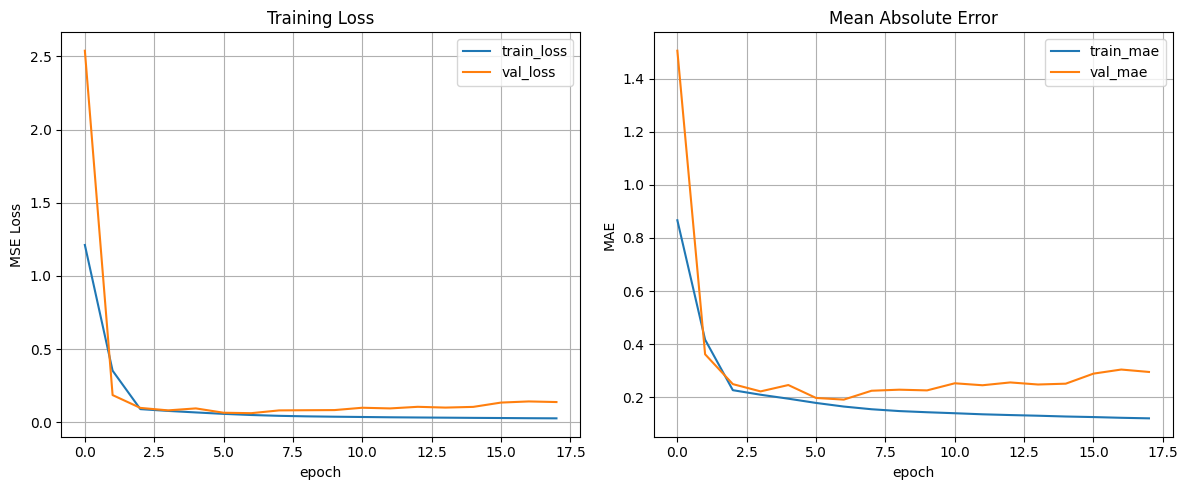

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_mae"], label="train_mae")
plt.plot(history["val_mae"], label="val_mae")
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Evaluation

In [5]:
from src.models.v2.build_model import build_model

preds, targets = evaluate_best_model(
    args=args,
    task=task,
    model_builder=build_model,
    best_model_path=best_path,
)

Evaluating best model on the test set...
Loaded checkpoint from epoch 6
Validation MSE: 0.061520, MAE: 0.190656


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/models/s4/s4_block.py:322: RuntimeWarning: divide by zero encountered in matmul
  A = T @ M @ np.linalg.inv(T)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/models/s4/s4_block.py:322: RuntimeWarning: overflow encountered in matmul
  A = T @ M @ np.linalg.inv(T)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/models/s4/s4_block.py:322: RuntimeWarning: invalid value encountered in matmul
  A = T @ M @ np.linalg.inv(T)


Testing:   0%|          | 0/216 [00:00<?, ?it/s]


TEST SET RESULTS:
MSE:  0.046699
MAE:  0.165600
RMSE: 0.216098
